In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, gaussian_vel_reconstruction, normalize_matrix, moca, smooth

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)
    

#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}
    

#### Ship Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})

df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

# df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
# df_sadcp = df_sadcp[df_sadcp['Lon'] <= 155]
df_sadcp= df_sadcp.reset_index().drop(columns=['index'])

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-09 11:56:08.499988,151.320299,-33.889224,NaN,0.005571,0.025212,-0.104460,0.036320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-09 12:13:38.666652,151.336628,-33.915619,NaN,-0.007718,0.051367,0.266196,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-09 12:26:08.500002,151.372994,-33.939047,NaN,-0.006178,-0.001007,0.025207,0.039912,0.058620,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-09 12:43:38.666665,151.426511,-33.973251,NaN,-0.040717,0.011668,0.069795,0.072353,0.056161,0.063086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-09 12:56:08.749984,151.464043,-33.998656,NaN,-0.054494,-0.046787,0.008042,0.045238,0.037273,0.037848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,2023-11-01 03:40:29.666685,152.133657,-33.499170,NaN,-0.193570,-0.174856,-0.137530,-0.129104,-0.171884,-0.182623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2170,2023-11-01 03:55:29.333340,152.162703,-33.499744,NaN,-0.265587,-0.234279,-0.260916,-0.220431,-0.168265,-0.207625,...,0.099449,0.131495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171,2023-11-01 04:10:29.666658,152.191377,-33.499695,NaN,-0.273816,-0.266387,-0.292629,-0.261923,-0.164615,-0.147517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2172,2023-11-01 04:25:29.333353,152.220223,-33.499658,NaN,-0.283102,-0.277454,-0.314878,-0.320812,-0.254559,-0.195608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### SWOT Data

In [4]:
lon0, lon1 = 153, 156
lat0, lat1 = -39, -37
tim0, tim1 = pd.Timestamp('2023-10-16 17:12:30.333340'), pd.Timestamp('2023-10-22 05:57:30.333340')


(-39.0, -37.0)

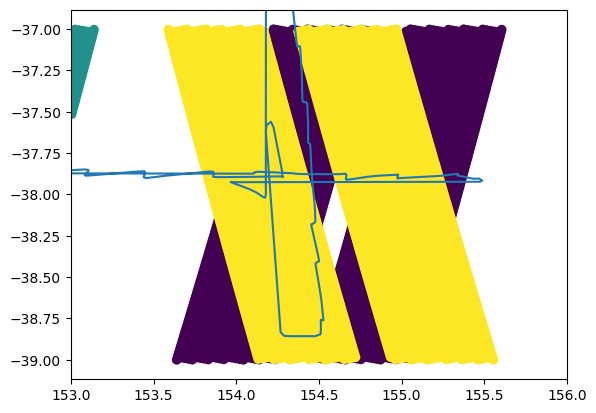

In [5]:
swot_path1 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_211_20231020T043758_20231020T052925_v2.0.1.nc'
swot_dataset1 = nc.Dataset(swot_path1, mode='r')

u_swot1, v_swot1 = swot_dataset1['ugos_filtered'][:].data, swot_dataset1['vgos_filtered'][:].data
lon_swot1, lat_swot1 = swot_dataset1['longitude'][:].data, swot_dataset1['latitude'][:].data
time_swot1 = swot_dataset1['time'][:].data

swot_path2 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_239_20231021T043829_20231021T052956_v2.0.1.nc'
swot_dataset2 = nc.Dataset(swot_path2, mode='r')

u_swot2, v_swot2 = swot_dataset2['ugos_filtered'][:].data, swot_dataset2['vgos_filtered'][:].data
lon_swot2, lat_swot2 = swot_dataset2['longitude'][:].data, swot_dataset2['latitude'][:].data
time_swot2 = swot_dataset2['time'][:].data

swot_path3 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_226_20231020T172941_20231020T182107_v2.0.1.nc'
swot_dataset3 = nc.Dataset(swot_path3, mode='r')

u_swot3, v_swot3 = swot_dataset3['ugos_filtered'][:].data, swot_dataset3['vgos_filtered'][:].data
lon_swot3, lat_swot3 = swot_dataset3['longitude'][:].data, swot_dataset3['latitude'][:].data
time_swot3 = swot_dataset3['time'][:].data

df_time1 = pd.DataFrame({'Time': pd.to_datetime(time_swot1, unit='s', origin='2000-01-01')})
df_time1 = df_time1.loc[df_time1.index.repeat(lon_swot1.shape[1])].reset_index(drop=True)
df_swot1 = pd.concat([
    pd.DataFrame({'ID': [1]*len(df_time1)}),
    df_time1,
    pd.DataFrame({'Lon': lon_swot1.ravel()}),
    pd.DataFrame({'Lat': lat_swot1.ravel()}),
    pd.DataFrame({'u': u_swot1.ravel()}),
    pd.DataFrame({'v': v_swot1.ravel()}),
], axis=1)

df_time2 = pd.DataFrame({'Time': pd.to_datetime(time_swot2, unit='s', origin='2000-01-01')})
df_time2 = df_time2.loc[df_time2.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot2 = pd.concat([
    pd.DataFrame({'ID': [2]*len(df_time2)}),
    df_time2,
    pd.DataFrame({'Lon': lon_swot2.ravel()}),
    pd.DataFrame({'Lat': lat_swot2.ravel()}),
    pd.DataFrame({'u': u_swot2.ravel()}),
    pd.DataFrame({'v': v_swot2.ravel()}),
], axis=1)

df_time3 = pd.DataFrame({'Time': pd.to_datetime(time_swot3, unit='s', origin='2000-01-01')})
df_time3 = df_time3.loc[df_time3.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot3 = pd.concat([
    pd.DataFrame({'ID': [3]*len(df_time3)}),
    df_time3,
    pd.DataFrame({'Lon': lon_swot3.ravel()}),
    pd.DataFrame({'Lat': lat_swot3.ravel()}),
    pd.DataFrame({'u': u_swot3.ravel()}),
    pd.DataFrame({'v': v_swot3.ravel()}),
], axis=1)

df_swot = pd.concat([df_swot1, df_swot2, df_swot3], axis=0)
df_swot = df_swot[np.hypot(df_swot.u, df_swot.v) < 100]  # FILTER!!
df_swot= df_swot.reset_index().drop(columns=['index'])

df = df_swot.copy()
df_CE = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= tim0) & (df.Time <= tim1)]

# plt.figure(figsize=(15,10))
plt.scatter(df_CE.Lon, df_CE.Lat, c=df_CE.ID)
plt.plot(df_sadcp.Lon, df_sadcp.Lat)
plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


#### ESPRA App. 1

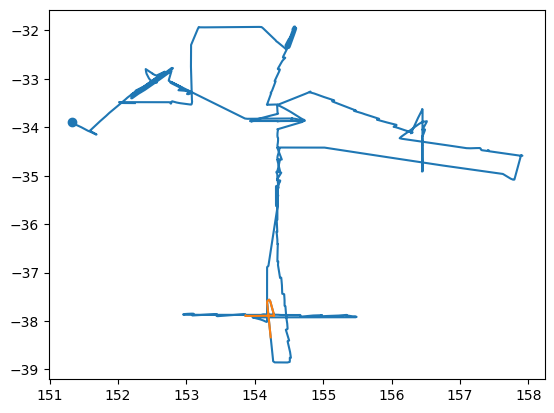

In [6]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t1 = pd.Timestamp('2023-10-19 5:00:00')
days1 = .3

# t1 = pd.Timestamp('2023-10-19 6:00:00')
# days1 = .4

df1 = df_sadcp[(df_sadcp.Time >= t1 - pd.Timedelta(days=days1)) & (df_sadcp.Time <= t1 + pd.Timedelta(days=days1))]
plt.plot(df1.Lon, df1.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [7]:
# find & sort your u_/v_ columns by the number after the underscore
import re

def depth_key(col):
    # assumes columns like 'u_10', 'v_219', etc.
    return int(re.split(r'u_|v_', col)[1])

u_cols = sorted([c for c in df1.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df1.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df1[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0, q = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col]
    )
    w /= deg_to_m(df_clean.Lat.mean())
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'q': q, 
        'Depth': depth
    })

# build your DataFrame once
df_results1 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'q', 'Depth'])
df_results1 = df_results1[df_results1['Depth'] <= 680]

wdw = round(len(df_results1)*.1)
sQ11 = smooth(df_results1.Q.apply(lambda Q: Q[0, 0]), np.arange(len(df_results1)), num=len(df_results1), window=wdw)
sQ12 = smooth(df_results1.Q.apply(lambda Q: Q[0, 1]), np.arange(len(df_results1)), num=len(df_results1), window=wdw)
sQ22 = smooth(df_results1.Q.apply(lambda Q: Q[1, 1]), np.arange(len(df_results1)), num=len(df_results1), window=wdw)

df_results1['sw'] = 2*(sQ11 + sQ22) / deg_to_m(df_results1.yc.mean())
df_results1['sQ'] = [np.array([[sQ11[i], sQ12[i]], 
                [sQ12[i], sQ22[i]]]) for i in range(len(sQ11))]

df_results1['sRc'] = smooth(df_results1.Rc, np.arange(len(df_results1)), num=len(df_results1), window=wdw)
df_results1['spsi0'] = smooth(df_results1.psi0, np.arange(len(df_results1)), num=len(df_results1), window=wdw)

s = -df_results1.sRc**2/df_results1.spsi0
df_results1['sq']  = s*df_results1.sQ

df_results1 = df_results1.reset_index().drop(columns=['index'])
df_results1.head()

,xc,yc,w,Q,Rc,psi0,q,Depth,sw,sQ,sRc,spsi0,sq
0,154.345586,-37.923586,-0.000025,"[[-0.8469194101978027, -0.02526943043219398], ...",0.486297,3.259423,"[[0.06144765039984196, 0.001833405998615536], ...",37,-0.000024,"[[-0.8182194149941088, -0.010664820935559122],...",0.493642,3.477770,"[[0.05733139307788029, 0.0007472678232233701],..."
1,154.351620,-37.917914,-0.000024,"[[-0.8220455325771786, -0.012342772674778676],...",0.491989,3.577490,"[[0.0556195753986605, 0.0008351116187702489], ...",47,-0.000024,"[[-0.7981248541962132, -0.004348155354683589],...",0.497797,3.493964,"[[0.056605205215137226, 0.0003083831118215666]..."
2,154.362663,-37.909006,-0.000024,"[[-0.7856933022073451, 0.0056177403002952864],...",0.502639,3.596398,"[[0.055194713185665586, -0.0003946445308305881...",57,-0.000023,"[[-0.7713741077632901, 0.0013964638716342714],...",0.503040,3.433535,"[[0.056849790597549334, -0.0001029185162950960..."
3,154.370480,-37.901684,-0.000022,"[[-0.7378411718025264, 0.014601841387943008], ...",0.510262,3.542545,"[[0.05422922315425454, -0.0010731937242744686]...",67,-0.000023,"[[-0.753643341848396, 0.007396900383162611], [...",0.505236,3.297800,"[[0.05833508437614251, -0.0005725504147829554]..."
4,154.384322,-37.891320,-0.000021,"[[-0.6643711220315979, 0.024374940776905715], ...",0.524014,3.191820,"[[0.05715554771114902, -0.00209696515145131], ...",77,-0.000022,"[[-0.7277887580690209, 0.02063087970478129], [...",0.508855,3.153152,"[[0.0597653206070817, -0.001694188219166549], ..."


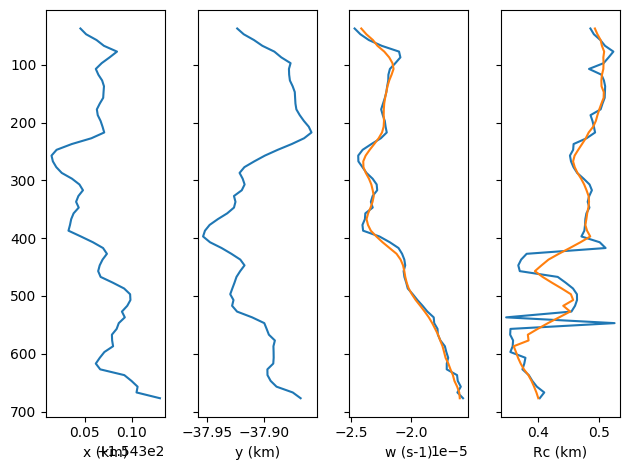

In [8]:
fig, axs = plt.subplots(1, 4, sharey=True)
mask = df_results1.Depth <= 680
axs[0].plot(df_results1.xc[mask], df_results1.Depth[mask])
axs[0].set_xlabel('x (km)')
axs[0].invert_yaxis()
axs[1].plot(df_results1.yc[mask], df_results1.Depth[mask])
axs[1].set_xlabel('y (km)')
axs[2].plot(df_results1.w[mask], df_results1.Depth[mask])
axs[2].plot(df_results1.sw[mask], df_results1.Depth[mask])
axs[2].set_xlabel('w (s-1)')
axs[3].plot(df_results1.Rc[mask], df_results1.Depth[mask])
axs[3].plot(df_results1.sRc[mask], df_results1.Depth[mask])
axs[3].set_xlabel('Rc (km)')
plt.tight_layout()


#### ESPRA App. 2

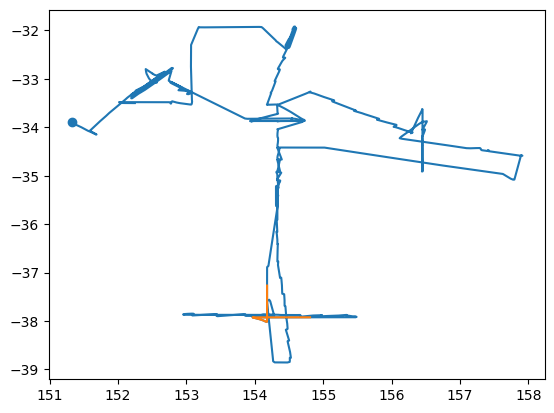

In [9]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t2 = pd.Timestamp('2023-10-21 13:30:00')
days2 = .3
df2 = df_sadcp[(df_sadcp.Time >= t2 - pd.Timedelta(days=days2)) & (df_sadcp.Time <= t2 + pd.Timedelta(days=days2))].copy()
plt.plot(df2.Lon, df2.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [10]:
u_cols = sorted([c for c in df2.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df2.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df2[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0, q = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col]
    )
    w /= deg_to_m(df_clean.Lat.mean())
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'q': q,
        'Depth': depth
    })

# build your DataFrame once
df_results2 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'q', 'Depth'])
df_results2 = df_results2[df_results2['Depth'] <= 680]

wdw = round(len(df_results2)*.1)
sQ11 = smooth(df_results2.Q.apply(lambda Q: Q[0, 0]), np.arange(len(df_results2)), num=len(df_results2), window=wdw)
sQ12 = smooth(df_results2.Q.apply(lambda Q: Q[0, 1]), np.arange(len(df_results2)), num=len(df_results2), window=wdw)
sQ22 = smooth(df_results2.Q.apply(lambda Q: Q[1, 1]), np.arange(len(df_results2)), num=len(df_results2), window=wdw)

df_results2['sw'] = 2*(sQ11 + sQ22) / deg_to_m(df_results2.yc.mean())
df_results2['sQ'] = [np.array([[sQ11[i], sQ12[i]], 
                [sQ12[i], sQ22[i]]]) for i in range(len(sQ11))]

df_results2['sRc'] = smooth(df_results2.Rc, np.arange(len(df_results2)), num=len(df_results2), window=wdw)
df_results2['spsi0'] = smooth(df_results2.psi0, np.arange(len(df_results2)), num=len(df_results2), window=wdw)

s = -df_results2.sRc**2/df_results2.spsi0
df_results2['sq']  = s*df_results2.sQ

df_results2 = df_results2.reset_index().drop(columns=['index'])
df_results2.head()


,xc,yc,w,Q,Rc,psi0,q,Depth,sw,sQ,sRc,spsi0,sq
0,154.260387,-37.891858,-0.00002,"[[-0.8514094446398511, 0.06787003483891164], [...",0.394437,0.995349,"[[0.13308138428708252, -0.010608571756912499],...",37,-0.00002,"[[-0.846158568592902, 0.063919372621086], [0.0...",0.395406,0.972559,"[[0.13602596987580062, -0.010275490880030375],..."
1,154.258241,-37.896840,-0.00002,"[[-0.845664697003091, 0.06365520761252139], [0...",0.396196,0.982428,"[[0.1351194728496306, -0.010170766412762107], ...",47,-0.00002,"[[-0.8439276412732581, 0.06340136331951153], [...",0.404721,0.958535,"[[0.14421406375362328, -0.010834303564262694],..."
2,154.259191,-37.892383,-0.00002,"[[-0.841401564135764, 0.06023287541182498], [0...",0.395585,0.939900,"[[0.14008789979250041, -0.010028382849005979],...",57,-0.00002,"[[-0.8409868580933564, 0.06559115342546666], [...",0.409855,0.956188,"[[0.14774243503050394, -0.011522887225024972],..."
3,154.261170,-37.885360,-0.00002,"[[-0.8372348593143267, 0.06184733541478809], [...",0.432665,0.916464,"[[0.17101533684502787, -0.01263306559833111], ...",67,-0.00002,"[[-0.8369761496279148, 0.06792174027638485], [...",0.413604,0.965615,"[[0.14827865619844358, -0.012033012385501491],..."
4,154.264463,-37.875543,-0.00002,"[[-0.8292237253737494, 0.07435031384928717], [...",0.430390,0.946801,"[[0.1622327454861473, -0.014546201675657488], ...",77,-0.00002,"[[-0.8296724074926609, 0.0699649409234292], [0...",0.414265,0.976343,"[[0.14583494035564043, -0.01229802617805445], ..."


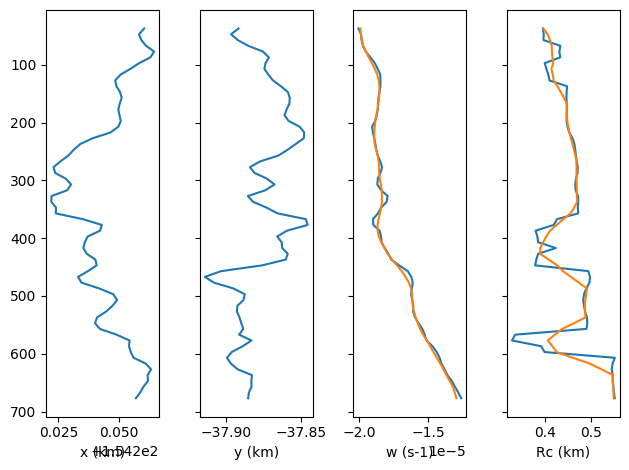

In [11]:
fig, axs = plt.subplots(1, 4, sharey=True)
mask = df_results2.Depth <= 680
axs[0].plot(df_results2.xc[mask], df_results2.Depth[mask])
axs[0].set_xlabel('x (km)')
axs[0].invert_yaxis()
axs[1].plot(df_results2.yc[mask], df_results2.Depth[mask])
axs[1].set_xlabel('y (km)')
axs[2].plot(df_results2.w[mask], df_results2.Depth[mask])
axs[2].plot(df_results2.sw[mask], df_results2.Depth[mask])
axs[2].set_xlabel('w (s-1)')
axs[3].plot(df_results2.Rc[mask], df_results2.Depth[mask])
axs[3].plot(df_results2.sRc[mask], df_results2.Depth[mask])
axs[3].set_xlabel('Rc (km)')
plt.tight_layout()


### Case 1 Analysis

In [12]:
records = []
cols_u = [c for c in df1.columns if c.startswith('u_')]

for _, row in df1.iterrows():
    lon, lat = row['Lon'], row['Lat']
    for u_col in cols_u:
        u_val = row[u_col]
        if pd.notna(u_val):
            depth = int(u_col.split('_')[1])
            if depth <= 680:
                v_col = f'v_{depth}'
                v_val = row.get(v_col, np.nan)
                records.append({
                    'Lon': lon,
                    'Lat': lat,
                    'u': u_val,
                    'v': v_val,
                    'Depth': depth
                })

df_valid1 = pd.DataFrame.from_records(records)
df_valid1.head()


,Lon,Lat,u,v,Depth
0,154.232169,-38.336258,-0.537643,0.289248,37
1,154.232169,-38.336258,-0.539361,0.292095,47
2,154.232169,-38.336258,-0.535849,0.278034,57
3,154.232169,-38.336258,-0.540946,0.263690,67
4,154.232169,-38.336258,-0.527578,0.253506,77


In [13]:
x, y = np.linspace(152, 157, 50), np.linspace(-39.5, -36.5, 50)
X, Y = np.meshgrid(x, y)

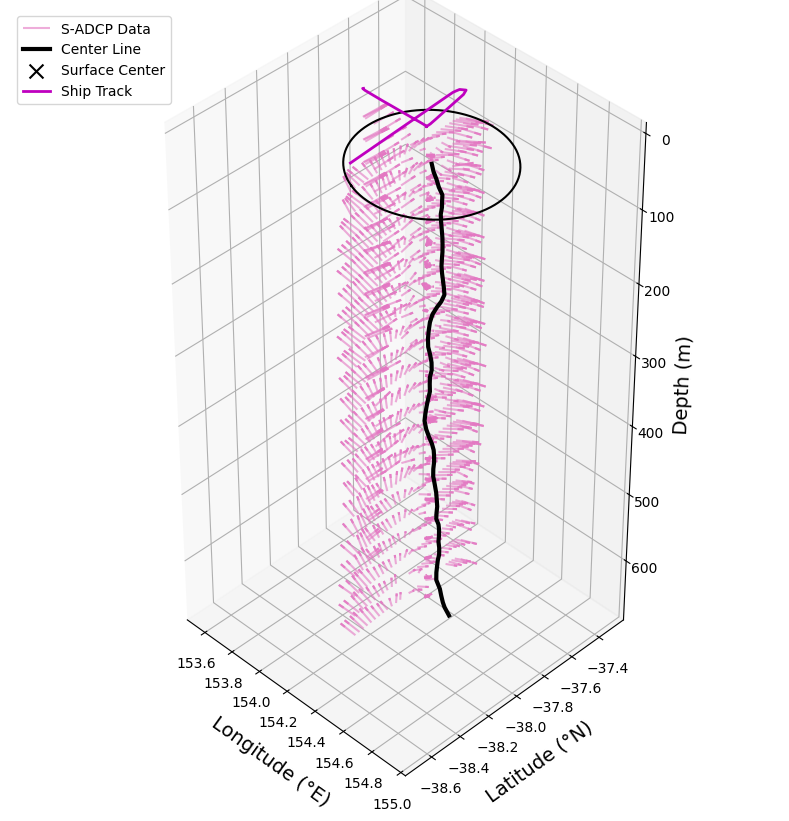

In [14]:
from mpl_toolkits.mplot3d import Axes3D

z = df_results1.Depth.values 

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(df_valid1.Lon, df_valid1.Lat,
#            df_valid1.Depth/1000, zorder=1, color='#e377c2',
#            marker='.', s=2, alpha=.7, label='S-ADCP Data')
# ax.quiver(df_valid1.Lon, df_valid1.Lat, df_valid1.Depth/1000,
#           df_valid1.u, df_valid1.v, [0]*len(df_valid1),
#           zorder=1, color='#e377c2', length=.15, label='S-ADCP Data')
# take every 4th row

depths = np.arange(37, 678, 30)
sub = df_valid1[df_valid1['Depth'].isin(depths)]
ax.quiver(
    sub.Lon,
    sub.Lat,
    sub.Depth,
    sub.u,
    sub.v,
    np.zeros(len(sub)),      # zero vertical component
    length=.2, #0.15,
    color='#e377c2',
    label='S‑ADCP Data',
    alpha=.6
)
# ax.quiver(
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,      # zero vertical component
#     length=.2, #0.15,
#     color='#e377c2',
#     label='S‑ADCP Data',
#     alpha=.6
# )

ax.plot(df_results1.xc, df_results1.yc, z,
        color='k', linewidth=3, label='Center Line', zorder=9)
ax.scatter(df_results1.iloc[0].xc, df_results1.iloc[0].yc, 5000, #df_results1.iloc[0].Depth,
           marker='x', zorder=10, color='k', s=100, label='Surface Center')

# Ellipse
x_ell, y_ell = plot_ellipse(df_results1.iloc[0].Q, (df_results1.iloc[0].xc, df_results1.iloc[0].yc), scale=df_results1.iloc[0].sRc)
ax.plot(x_ell, y_ell, [df_results1.iloc[0].Depth] * len(x_ell), color='k', zorder=10)

# for Q, xc, yc, scale, d in zip(np.flip(df_results1.sQ), np.flip(df_results1.xc), np.flip(df_results1.yc),
#                                np.flip(df_results1.sRc), np.flip(df_results1.Depth)):
#     x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=scale)
#     ax.plot(x_ell, y_ell, [d] * len(x_ell), zorder=10)

mask = (
    (df_sadcp.Lon >= X.min()) &
    (df_sadcp.Lon <= X.max()) &
    (df_sadcp.Lat >= Y.min()) &
    (df_sadcp.Lat <= Y.max())
)
# ax.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], [0]*mask.sum(),
#         color='m', linewidth=.5, alpha=.4, zorder=10)
ax.plot(df1.Lon, df1.Lat, [0]*len(df1),
        color='m', linewidth=2, label='Ship Track', zorder=11)

# your quiver and surface calls here, e.g.
# ax.quiver(..., ax.plot_surface(...), etc.

# closest = min(tim_ssh, key=lambda tt: abs(tt - t1))
# ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
# mask = np.hypot(lon_ssh - df_results1.iloc[0].xc, lat_ssh - df_results1.iloc[0].yc) < 1
# depth = 0
# ax.quiver(lon_ssh[mask], lat_ssh[mask], depth*np.ones_like(lon_ssh[mask]),
#           ut[mask], vt[mask], depth*np.ones_like(ut[mask]), length=.1, alpha=.4)

ax.invert_zaxis()
ax.set_zlim(z.max(), 0)
ax.set_box_aspect((1, 1, 2))
ax.view_init(elev=40, azim=315)
ax.set_xlabel('Longitude (°E)', fontsize=14, labelpad=10)
ax.set_ylabel('Latitude (°N)', fontsize=14, labelpad=10)
ax.set_zlabel('Depth (m)', fontsize=14, labelpad=10)
ax.legend(loc='upper left')

ax.set_xlim(153.5, 155)
ax.set_ylim(-38.75, -37.25)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Latitude (°N)')

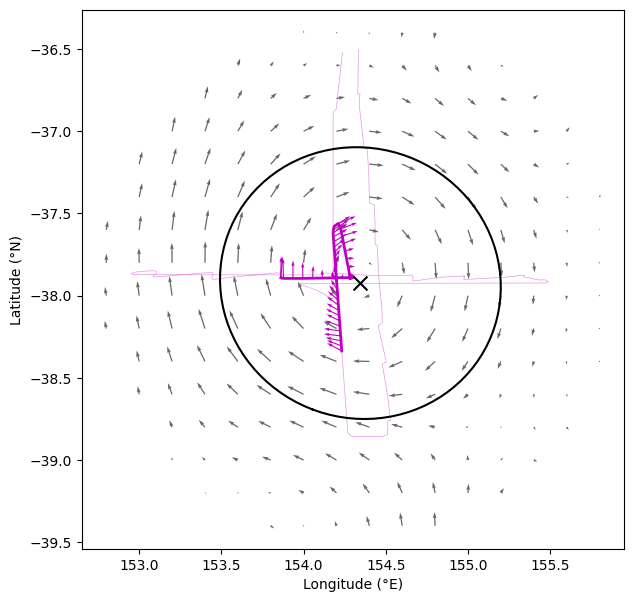

In [15]:
plt.figure(figsize=(7,7))
scale = 20
closest = min(tim_ssh, key=lambda tt: abs(tt - t1))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = np.hypot(lon_ssh - df_results1.iloc[0].xc, lat_ssh - df_results1.iloc[0].yc) < 1.6
plt.quiver(lon_ssh[mask], lat_ssh[mask], ut[mask], vt[mask], scale=scale, zorder=1, width=.0023, color='k', alpha=.6)#'#1f77b4')
mask = (
    (df_sadcp.Lon >= X.min()) &
    (df_sadcp.Lon <= X.max()) &
    (df_sadcp.Lat >= Y.min()) &
    (df_sadcp.Lat <= Y.max())
)
plt.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], color='m', linewidth=.5, alpha=.4, zorder=2)
plt.plot(df1.Lon, df1.Lat, color='m', linewidth=2, label='Ship Track', zorder=3)
plt.quiver(df1.Lon, df1.Lat, df1.u_37, df1.v_37, scale=scale, color='m', width=.002, zorder=3)

plt.scatter(df_results1.iloc[0].xc, df_results1.iloc[0].yc, marker='x', zorder=4, color='k', s=100)
x_ell, y_ell = plot_ellipse(df_results1.iloc[0].Q, (df_results1.iloc[0].xc, df_results1.iloc[0].yc), scale=1)
plt.plot(x_ell, y_ell, color='k')

plt.axis('equal')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')



(-39.5, -36.5)

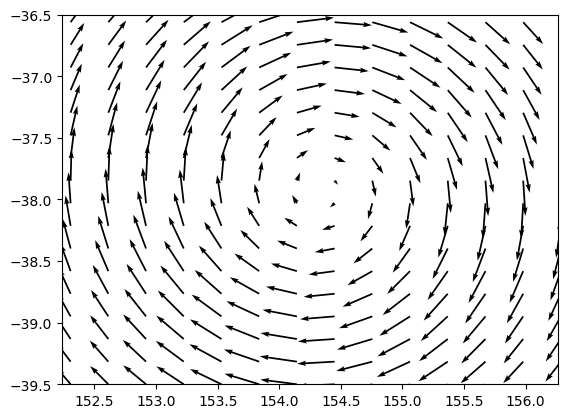

In [16]:
data = df_results1.iloc[0]
u, v, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.sq[0,0], data.sq[1,0], data.sq[1,1],
                                       data.sRc, data.spsi0, X, Y)
spac = 3
plt.quiver(X[::spac, ::spac], Y[::spac, ::spac], u[::spac, ::spac], v[::spac, ::spac], scale=20)
plt.axis('equal')
plt.xlim(152.5, 156)
plt.ylim(-39.5, -36.5)


### Case 2 Analysis

In [17]:
records = []
cols_u = [c for c in df2.columns if c.startswith('u_')]

for _, row in df2.iterrows():
    lon, lat = row['Lon'], row['Lat']
    for u_col in cols_u:
        u_val = row[u_col]
        if pd.notna(u_val):
            depth = int(u_col.split('_')[1])
            if depth <= 680:
                v_col = f'v_{depth}'
                v_val = row.get(v_col, np.nan)
                records.append({
                    'Lon': lon,
                    'Lat': lat,
                    'u': u_val,
                    'v': v_val,
                    'Depth': depth
                })

df_valid2 = pd.DataFrame.from_records(records)
df_valid2.head()


,Lon,Lat,u,v,Depth
0,154.807658,-37.924245,-0.089735,-0.660314,37
1,154.807658,-37.924245,-0.088553,-0.654834,47
2,154.807658,-37.924245,-0.077875,-0.640587,57
3,154.807658,-37.924245,-0.081858,-0.628039,67
4,154.807658,-37.924245,-0.112915,-0.621663,77


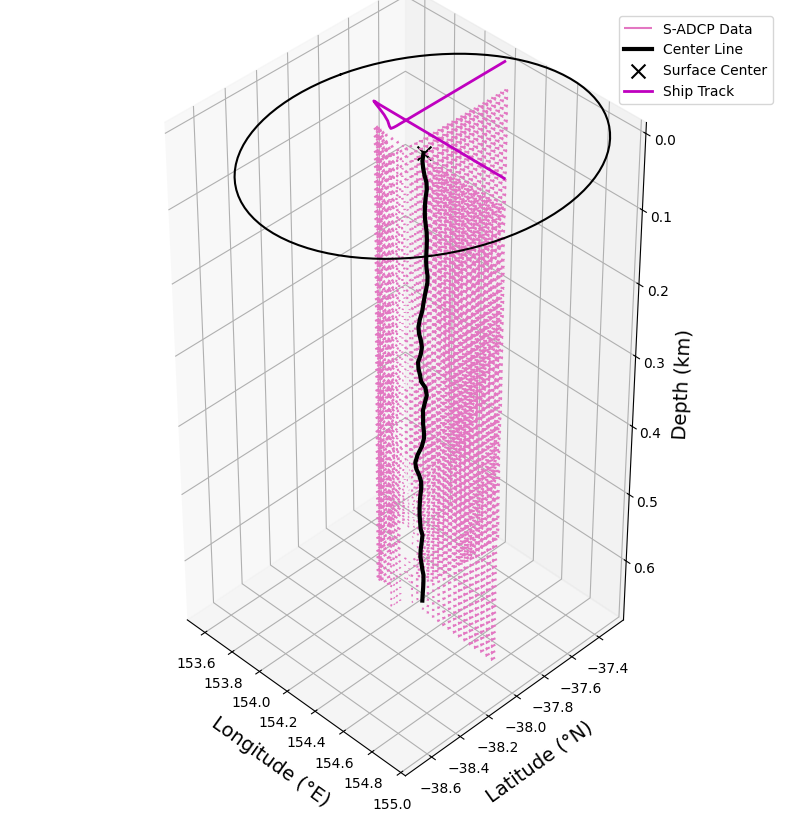

In [18]:
from mpl_toolkits.mplot3d import Axes3D

z = df_results1.Depth.values / 1000

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# for k in range(len(df_results2)):
#     data = df_results2.iloc[k]
#     x_ell, y_ell = plot_ellipse(data.Q, (data.xc, data.yc), scale=1)
#     ax.plot(x_ell, y_ell, data.Depth/1000, alpha=.2, color='r')

# ax.scatter(df_valid2.Lon, df_valid2.Lat,
#            df_valid2.Depth/1000, zorder=1, color='#e377c2',
#            marker='.', s=2, alpha=.7, label='S-ADCP Data')
ax.quiver(df_valid2.Lon, df_valid2.Lat, df_valid2.Depth/1000,
          df_valid2.u, df_valid2.v, [0]*len(df_valid2),
          zorder=1, color='#e377c2', length=.05, label='S-ADCP Data')

ax.plot(df_results2.xc, df_results2.yc, z,
        color='k', linewidth=3, label='Center Line',
       zorder=9)
ax.scatter(df_results2.iloc[0].xc, df_results2.iloc[0].yc, df_results2.iloc[0].Depth/1000,
           marker='x', zorder=9, color='k', s=100, label='Surface Center')

# Ellipse
x_ell, y_ell = plot_ellipse(df_results2.iloc[0].Q, (df_results2.iloc[0].xc, df_results2.iloc[0].yc), scale=1)
ax.plot(x_ell, y_ell, [df_results2.iloc[0].Depth/1000] * len(x_ell), color='k', zorder=10)

mask = (
    (df_sadcp.Lon >= X.min()) &
    (df_sadcp.Lon <= X.max()) &
    (df_sadcp.Lat >= Y.min()) &
    (df_sadcp.Lat <= Y.max())
)
# ax.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], [0]*mask.sum(),
#         color='m', linewidth=.5, alpha=.4, zorder=10)
ax.plot(df2.Lon, df2.Lat, [0]*len(df2),
        color='m', linewidth=2, label='Ship Track', zorder=11)

# your quiver and surface calls here, e.g.
# ax.quiver(..., ax.plot_surface(...), etc.

# closest = min(tim_ssh, key=lambda tt: abs(tt - t1))
# ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
# mask = np.hypot(lon_ssh - df_results2.iloc[0].xc, lat_ssh - df_results2.iloc[0].yc) < 1
# depth = 0
# ax.quiver(lon_ssh[mask], lat_ssh[mask], depth*np.ones_like(lon_ssh[mask]),
#           ut[mask], vt[mask], depth*np.ones_like(ut[mask]), length=.1, alpha=.4)

ax.invert_zaxis()
ax.set_zlim(z.max(), 0)
ax.set_box_aspect((1, 1, 2))
ax.view_init(elev=40, azim=315)
ax.set_xlabel('Longitude (°E)', fontsize=14, labelpad=10)
ax.set_ylabel('Latitude (°N)', fontsize=14, labelpad=10)
ax.set_zlabel('Depth (km)', fontsize=14, labelpad=10)
ax.legend()

ax.set_xlim(153.5, 155)
ax.set_ylim(-38.75, -37.25)

plt.tight_layout()
plt.show()

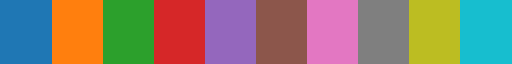

In [19]:
plt.get_cmap('tab10')

Text(0, 0.5, 'Latitude (°N)')

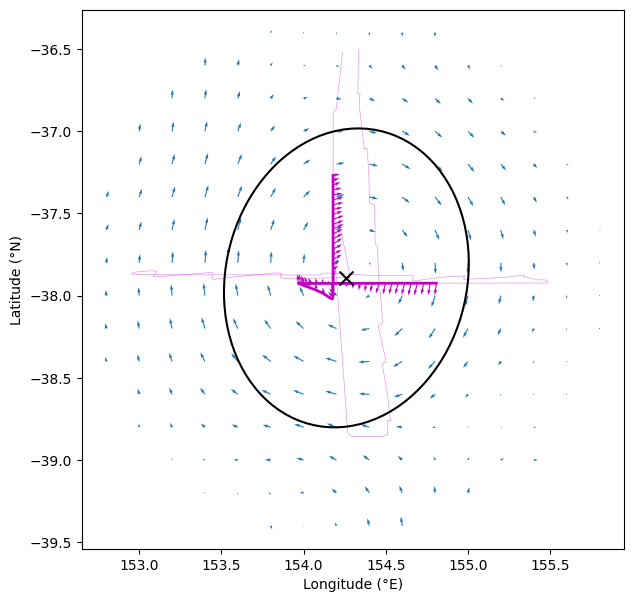

In [20]:
plt.figure(figsize=(7,7))
closest = min(tim_ssh, key=lambda tt: abs(tt - t2))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = np.hypot(lon_ssh - df_results2.iloc[0].xc, lat_ssh - df_results2.iloc[0].yc) < 1.6
plt.quiver(lon_ssh[mask], lat_ssh[mask], ut[mask], vt[mask], scale=30, zorder=1, width=.002, color='#1f77b4')
mask = (
    (df_sadcp.Lon >= X.min()) &
    (df_sadcp.Lon <= X.max()) &
    (df_sadcp.Lat >= Y.min()) &
    (df_sadcp.Lat <= Y.max())
)
plt.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], color='m', linewidth=.5, alpha=.4, zorder=2)
plt.plot(df2.Lon, df2.Lat, color='m', linewidth=2, label='Ship Track', zorder=3)
plt.quiver(df2.Lon, df2.Lat, df2.u_37, df2.v_37, scale=30, color='m', width=.002, zorder=3)

    
plt.scatter(df_results2.iloc[0].xc, df_results2.iloc[0].yc, marker='x', zorder=4, color='k', s=100)
x_ell, y_ell = plot_ellipse(df_results2.iloc[0].Q, (df_results2.iloc[0].xc, df_results2.iloc[0].yc), scale=1)
plt.plot(x_ell, y_ell, color='k')

plt.axis('equal')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')


(-39.5, -36.5)

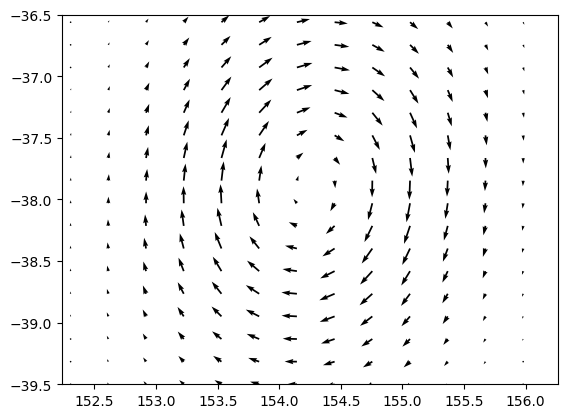

In [21]:
data = df_results2.iloc[0]
u, v, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.sq[0,0], data.sq[1,0], data.sq[1,1],
                                       data.sRc, data.spsi0, X, Y)
spac = 3
plt.quiver(X[::spac, ::spac], Y[::spac, ::spac], u[::spac, ::spac], v[::spac, ::spac], scale=20)
plt.axis('equal')
plt.xlim(152.5, 156)
plt.ylim(-39.5, -36.5)




### SWOT


In [22]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
swot_path1 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_211_20231020T043758_20231020T052925_v2.0.1.nc'
swot_dataset1 = nc.Dataset(swot_path1, mode='r')

u_swot1, v_swot1 = swot_dataset1['ugos_filtered'][:].data, swot_dataset1['vgos_filtered'][:].data
lon_swot1, lat_swot1 = swot_dataset1['longitude'][:].data, swot_dataset1['latitude'][:].data
time_swot1 = swot_dataset1['time'][:].data

swot_path2 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_226_20231020T172941_20231020T182107_v2.0.1.nc'
swot_dataset2 = nc.Dataset(swot_path2, mode='r')

u_swot2, v_swot2 = swot_dataset2['ugos_filtered'][:].data, swot_dataset2['vgos_filtered'][:].data
lon_swot2, lat_swot2 = swot_dataset2['longitude'][:].data, swot_dataset2['latitude'][:].data
time_swot2 = swot_dataset2['time'][:].data

swot_path3 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_239_20231021T043829_20231021T052956_v2.0.1.nc'
swot_dataset3 = nc.Dataset(swot_path3, mode='r')

u_swot3, v_swot3 = swot_dataset3['ugos_filtered'][:].data, swot_dataset3['vgos_filtered'][:].data
lon_swot3, lat_swot3 = swot_dataset3['longitude'][:].data, swot_dataset3['latitude'][:].data
time_swot3 = swot_dataset3['time'][:].data

df_time1 = pd.DataFrame({'Time': pd.to_datetime(time_swot1, unit='s', origin='2000-01-01')})
df_time1 = df_time1.loc[df_time1.index.repeat(lon_swot1.shape[1])].reset_index(drop=True)
df_swot1 = pd.concat([
    pd.DataFrame({'ID': [1]*len(df_time1)}),
    df_time1,
    pd.DataFrame({'Lon': lon_swot1.ravel()}),
    pd.DataFrame({'Lat': lat_swot1.ravel()}),
    pd.DataFrame({'u': u_swot1.ravel()}),
    pd.DataFrame({'v': v_swot1.ravel()}),
], axis=1)

df_time2 = pd.DataFrame({'Time': pd.to_datetime(time_swot2, unit='s', origin='2000-01-01')})
df_time2 = df_time2.loc[df_time2.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot2 = pd.concat([
    pd.DataFrame({'ID': [2]*len(df_time2)}),
    df_time2,
    pd.DataFrame({'Lon': lon_swot2.ravel()}),
    pd.DataFrame({'Lat': lat_swot2.ravel()}),
    pd.DataFrame({'u': u_swot2.ravel()}),
    pd.DataFrame({'v': v_swot2.ravel()}),
], axis=1)

df_time3 = pd.DataFrame({'Time': pd.to_datetime(time_swot3, unit='s', origin='2000-01-01')})
df_time3 = df_time3.loc[df_time3.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot3 = pd.concat([
    pd.DataFrame({'ID': [3]*len(df_time3)}),
    df_time3,
    pd.DataFrame({'Lon': lon_swot3.ravel()}),
    pd.DataFrame({'Lat': lat_swot3.ravel()}),
    pd.DataFrame({'u': u_swot3.ravel()}),
    pd.DataFrame({'v': v_swot3.ravel()}),
], axis=1)

df_swot = pd.concat([df_swot1, df_swot2, df_swot3], axis=0)
df_swot = df_swot[np.hypot(df_swot.u, df_swot.v) < 100]  # FILTER!!
df_swot= df_swot.reset_index().drop(columns=['index'])

df = df_swot.copy()
df_CE = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= tim0) & (df.Time <= tim1)]


In [ ]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)
plt.plot(df1.Lon, df1.Lat)
plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


In [ ]:
day_int = 1
# # df1_swot = df_CE[(df_CE.Time >= t1 - pd.Timedelta(days=day_int)) &
# #                  (df_CE.Time <= t1 + pd.Timedelta(days=day_int))].copy()
# df1_swot = df_CE[(df_CE.Time >= t1) &
#                  (df_CE.Time <= t1 + pd.Timedelta(days=day_int))].copy()

df = df_swot.copy()
df1_swot = df[(df.Lon >= X.min()) & (df.Lon <= X.max()) &
              (df.Lat >= Y.min()) & (df.Lat <= Y.max()) &
              (df.Time >= t1) & (df.Time <= t1 + pd.Timedelta(days=day_int))]

df1_swot

In [ ]:

plt.scatter(df1_swot.Lon, df1_swot.Lat, c=np.hypot(df1_swot.u, df1_swot.v), s=5, vmin=0, vmax=None)
plt.colorbar()
plt.plot(df1.Lon, df1.Lat, 'r')
spac = 10
plt.quiver(df1_swot.Lon[::spac], df1_swot.Lat[::spac],
           df1_swot.u[::spac], df1_swot.v[::spac], width=.0015)
plt.axis('equal')

data = df_results1.iloc[0]
plt.scatter(data.xc, data.yc, marker='x', color='r')

In [ ]:
df_results1